### K-MEANS

#### Import library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#### Import dataset

In [3]:
df = pd.read_csv('Mall_Customers.csv')
df.drop(columns=['CustomerID', 'Genre', 'Age'], inplace=True) #
df.rename(columns={'Annual Income (k$)': 'Annual_Income', 'Spending Score (1-100)':'Spending_Score'}, inplace=True)
df

,Annual_Income,Spending_Score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


#### Create Dummy Variables

In [4]:
X = pd.get_dummies(df) #no need to drop first for multicoliniarity
X  #there weren't any

,Annual_Income,Spending_Score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


#### Feature Scaling (Standard Scaler)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0:7]

array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992],
       [-1.66266033,  1.00159627],
       [-1.62449091, -1.71591298]])

#### FIT the model

In [6]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters = 5, init='k-means++')
model.fit(scaled_X)

KMeans(n_clusters=5)

#### PREDICT cluster

In [7]:
y_pred = model.predict(scaled_X)  #note this line and previous can be done in one step as fit_predict(scaled_X)
new_df = X.copy()
new_df['Cluster'] = y_pred
new_df

,Annual_Income,Spending_Score,Cluster
0,15,39,3
1,15,81,1
2,16,6,3
3,16,77,1
4,17,40,3
...,...,...,...
195,120,79,2
196,126,28,0
197,126,74,2
198,137,18,0


#### Centroids

In [8]:
scaled_centers = model.cluster_centers_
unscaled_centers = scaler.inverse_transform(scaled_centers)

#### Visualize

In [9]:
sorted(new_df['Cluster'].unique())

[0, 1, 2, 3, 4]

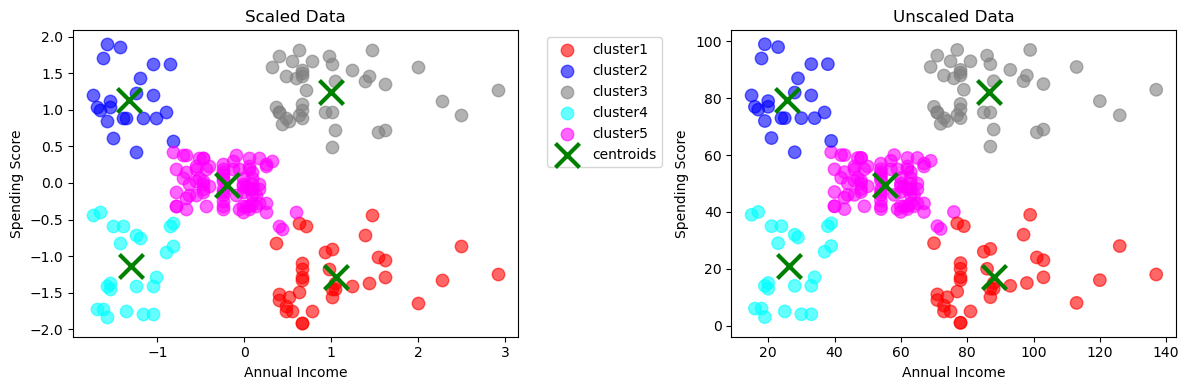

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


# Scaled Visual
axes[0].scatter(scaled_X[y_pred == 0, 0], scaled_X[y_pred == 0, 1], s=80, label='cluster1', alpha=0.6, color='red')
axes[0].scatter(scaled_X[y_pred == 1, 0], scaled_X[y_pred == 1, 1], s=80, label='cluster2', alpha=0.6, color='blue')
axes[0].scatter(scaled_X[y_pred == 2, 0], scaled_X[y_pred == 2, 1], s=80, label='cluster3', alpha=0.6, color='gray')
axes[0].scatter(scaled_X[y_pred == 3, 0], scaled_X[y_pred == 3, 1], s=80, label='cluster4', alpha=0.6, color='cyan')
axes[0].scatter(scaled_X[y_pred == 4, 0], scaled_X[y_pred == 4, 1], s=80, label='cluster5', alpha=0.6, color='magenta')

# Centroids for scaled data
centers = model.cluster_centers_
axes[0].scatter(centers[:, 0], centers[:, 1], s=300, color='green', label='centroids', marker='x', linewidths=3)

axes[0].set_xlabel('Annual Income')
axes[0].set_ylabel('Spending Score')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_title('Scaled Data')



# Unscaled Visual
colors = new_df['Cluster'].astype(str).map({'0': 'red', '1': 'blue', '2': 'gray', '3': 'cyan', '4': 'magenta'})
axes[1].scatter(new_df['Annual_Income'], new_df['Spending_Score'], s=80, alpha=0.6, c=colors)

# Centroids for unscaled data
axes[1].scatter(unscaled_centers[:, 0], unscaled_centers[:, 1], s=300, color='green', label='centroids', marker='x', linewidths=3)

axes[1].set_xlabel('Annual Income')
axes[1].set_ylabel('Spending Score')
axes[1].set_title('Unscaled Data')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [11]:
new_df.corr()['Cluster'].iloc[:-1].sort_values()

Annual_Income    -0.351306
Spending_Score    0.113257
Name: Cluster, dtype: float64

#### Final Notes

- Red  Cluster 1 - customers with have high income but spent low
- Blue Cluster 4 - customers with have low income and spend low >> they are preparing for recessiong
- Gray Cluster 3 - customers with high income and spend high
- Blue Cluster 2 - customers with low income and yet spend high >> majority of customers out there

#### Evaluate the Model:

- option 1 - Elbow Method
- option 2 - Silhouette Score
- option 3 - Davies-Bouldin Index (DBI)

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_avg = silhouette_score(scaled_X, model.labels_)
print(f'Silhouette Score: {silhouette_avg}')
#A score of 0.55 ---> 0.5 - 1.0: Good to excellent clustering, 

db_index = davies_bouldin_score(scaled_X, model.labels_)
print(f'Davies-Bouldin Index: {db_index}')
# DBI of 0.572 is less than 1 (Typically considered excellent clustering)

Silhouette Score: 0.5546571631111091
Davies-Bouldin Index: 0.5722356162263352


#### Elbow Method

In [13]:
k_values = np.array(range(2, 18))

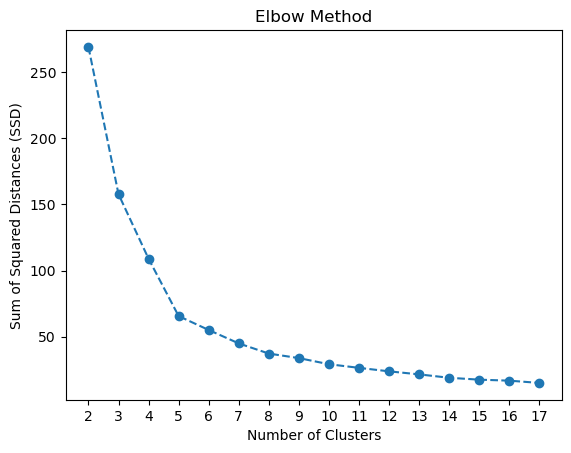

In [14]:
#To evaluate the model we measure the sum of the squared distances (SSD) from the point to the cluster center 

ssd = []

for k in k_values:
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(scaled_X)
    ssd.append(model.inertia_)  # SSD points to cluster center
    
plt.plot(k_values, ssd, 'o--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.xticks(k_values) 

plt.show()

#it looks like 5, 6, 7 is the optimal number of clusters

#### Silhouette Score

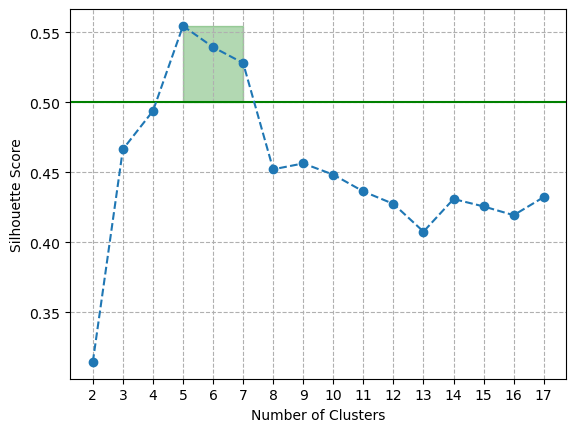

In [15]:
silhouette = []

for k in k_values:
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(scaled_X)
    silhouette.append(silhouette_score(scaled_X, model.labels_))

silhouette = np.array(silhouette)
plt.axhline(y=0.5, color='green')
plt.fill_between(k_values, 0.5, silhouette.max(), where=(silhouette >= 0.5) , color='green', alpha=0.3)

plt.plot(k_values, silhouette, 'o--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(k_values) 
plt.grid(True, linestyle='--') 

plt.show()

#above 0.5 is good

#### Davies-Bouldin Index

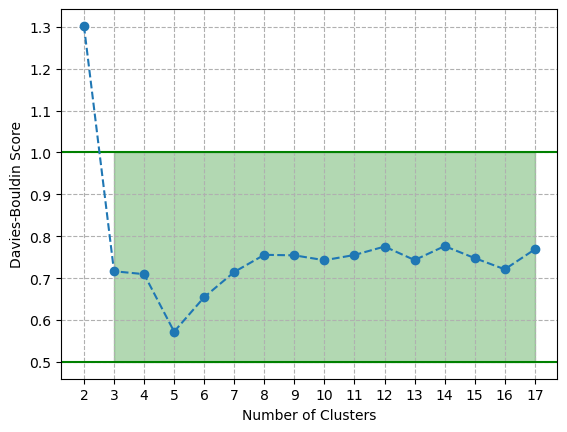

In [16]:
db_scores = []
k_values = np.array(range(2, 18))

for k in k_values:
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(scaled_X)
    db_scores.append(davies_bouldin_score(scaled_X, model.labels_))
    
db_scores = np.array(db_scores)
plt.axhline(y=1.0, color='green')
plt.axhline(y=0.5, color='green')
plt.fill_between(k_values, 0.5, 1, where=(db_scores >= 0.5) & (db_scores <= 1), color='green', alpha=0.3)

plt.plot(k_values, db_scores, 'o--')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(k_values) 
plt.grid(True, linestyle='--') 

plt.show()

#0.5 and 1 is excellent

Final notes:
- per Elbow method shows k=5 is where no longer significantly improving SSD
- per Silhouette score k 5, 6, and 7 are good
- per Davies-Bouldin score anything above 3 clusters wins

It seems that 5, 6 & 7 clusters are good in all three metrics